# Data analysis of Hes1 oscillations in single cells

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy
import pyboat as pb
from scipy.stats import norm, poisson
from scipy.signal import butter, filtfilt

In [2]:
# Import data
data = pd.read_csv('all_data.csv')
data['Smoothened spot cnt intensity ch1'] = data['Spot center intensity Center ch1']
dapt = pd.read_csv('all_dapt_data.csv')

# Split data into NT, PSM and SM cells
data_NT = data[data['Label'] == 'NT']
data_PSM = data[(data['Label'] == 'PSM')]
data_SM = data[(data['Label'] == 'SM')]

data

# split dapt data into NT, PSM and SM cells
dapt_NT = dapt[dapt['Label'] == 'NT']
dapt_PSM = dapt[(dapt['Label'] == 'PSM')]
dapt_SM = dapt[(dapt['Label'] == 'SM')]

data

,Unnamed: 0,Label,ID,Spot N links,Spot center intensity Center ch1,Spot center intensity Center ch2,Spot frame,Spot intensity Mean ch1,Spot intensity Std ch1,Spot intensity Min ch1,...,Spot position Z,Spot quick mean Mean ch1,Spot quick mean Mean ch2,Spot radius,Spot track ID,Track N spots,source_file,Time,Cell ID,Smoothened spot cnt intensity ch1
0,0,NT,2.0,1.0,220.854124,1080.042448,25.0,211.092105,86.669361,106.0,...,20.277662,208.391304,892.217391,5.0,0,80.0,221209_nb004_table-Spot.csv,250.0,0,220.854124
1,1,NT,3.0,2.0,219.707999,1011.074329,26.0,200.581081,95.222595,0.0,...,19.655985,190.695652,785.391304,5.0,0,80.0,221209_nb004_table-Spot.csv,260.0,0,219.707999
2,2,NT,4.0,2.0,230.653049,1002.678139,27.0,213.257143,81.304346,26.0,...,19.825619,196.043478,835.000000,5.0,0,80.0,221209_nb004_table-Spot.csv,270.0,0,230.653049
3,3,NT,5.0,2.0,232.206549,1026.596045,28.0,205.400000,99.291408,26.0,...,20.096999,200.913043,787.565217,5.0,0,80.0,221209_nb004_table-Spot.csv,280.0,0,232.206549
4,4,NT,6.0,2.0,237.634189,1128.379149,29.0,213.921053,83.188743,53.0,...,19.961410,211.291667,853.375000,5.0,0,80.0,221209_nb004_table-Spot.csv,290.0,0,237.634189
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9190,9190,SM,528.0,2.0,97.639187,993.868923,135.0,98.266667,44.242676,20.0,...,19.976866,97.090909,812.818182,5.0,9,139.0,230110_nb008_table-Spot.csv,1350.0,78,97.639187
9191,9191,SM,529.0,2.0,95.955824,1179.533257,136.0,94.653333,44.006908,20.0,...,19.976866,93.500000,845.458333,5.0,9,139.0,230110_nb008_table-Spot.csv,1360.0,78,95.955824
9192,9192,SM,530.0,2.0,104.639059,1370.023991,137.0,100.657895,44.331344,20.0,...,19.976866,99.826087,1064.173913,5.0,9,139.0,230110_nb008_table-Spot.csv,1370.0,78,104.639059
9193,9193,SM,531.0,2.0,107.379943,1230.780257,138.0,94.085714,49.388652,0.0,...,19.976866,99.045455,946.636364,5.0,9,139.0,230110_nb008_table-Spot.csv,1380.0,78,107.379943


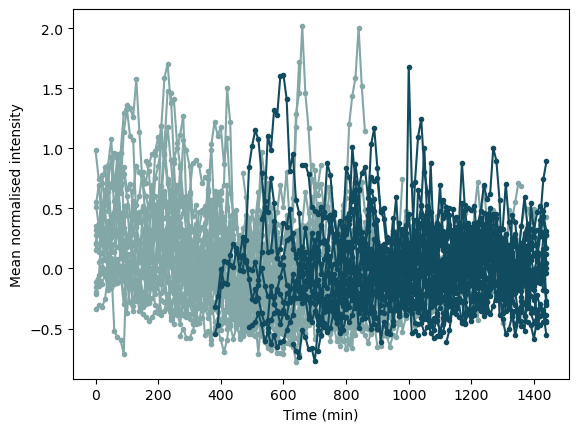

In [26]:
# select one cell to see data 
PSM_index = data_PSM['Cell ID'].unique()
SM_index = data_SM['Cell ID'].unique()
NT_index = data_NT['Cell ID'].unique()

colour_PSM = '#82A7A6'
colour_SM = '#114B5F'
colour_NT = '#E55934'

for i in PSM_index:
    cell_data = data_PSM[data_PSM['Cell ID'] == i]
    time = cell_data['Time']
    intensity_raw = cell_data['Spot center intensity Center ch1']
    intensity_mean = np.mean(intensity_raw)
    intensity = (intensity_raw - intensity_mean) / intensity_mean
    plt.plot(time, intensity, marker='.', linestyle='-', color = colour_PSM)
    plt.xlabel('Time (min)')
    plt.ylabel('Mean normalised intensity')

for i in SM_index:
    cell_data = data_SM[data_SM['Cell ID'] == i]
    time = cell_data['Time']
    intensity_raw = cell_data['Spot center intensity Center ch1']
    intensity_mean = np.mean(intensity_raw)
    intensity = (intensity_raw - intensity_mean) / intensity_mean
    plt.plot(time, intensity, marker='.', linestyle='-', color = colour_SM)
    plt.xlabel('Time (min)')
    plt.ylabel('Mean normalised intensity')



## Find period of each cell using wavelet transform 

In [8]:
def rolling_average(data, window_length):
    # Apply rolling average to smooth the data
    data = pd.Series(data)
    rolling = data.rolling(window=window_length, center=True)
    rolling_mean = rolling.mean()
    rolling_mean = rolling_mean.fillna(method='bfill')
    rolling_mean = rolling_mean.fillna(method='ffill')
    rolling_mean = rolling_mean.values
    return rolling_mean

# calculate the power spectrum of all data for PSM
def Fourier_analysis(type, trending = False):
    if type == 'PSM':
        data = data_PSM
        index = PSM_index

    elif type == 'NT':
        data = data_NT
        index = NT_index

    elif type == 'SM': 
        data = data_SM
        index = SM_index

    period_array = []
    magnitudes_array = []
    fs = 1/600

    window_length_smooth = 5
    for i in index:
        signal = data[data['Cell ID'] == i]['Spot center intensity Center ch1'].values # Signal converted to array
        signal = signal - np.mean(signal) # Remove DC component
        signal = rolling_average(signal, window_length_smooth)
        
        # save smoothened signal to data 
        data.loc[data['Cell ID'] == i, 'Smoothened spot cnt intensity ch1'] = signal

        signal = signal / np.std(signal) # Normalize signal

        if trending == True:
            #determine trend
            window_length_trend = 15
            trend = rolling_average(signal, window_length_trend)
            signal = signal - trend

        signal = signal**2 # Square signal to get power

        # Compute FFT
        fft_result = scipy.fft.fft(signal)
        frequencies = scipy.fft.fftfreq(len(fft_result), 1/fs)  # Frequency axis 
    
        # Filter positive frequencies
        positive_frequencies = frequencies[frequencies > 0]
        positive_magnitude = np.abs(fft_result[1:len(positive_frequencies)])
        # Calculate period
        period = 1 / positive_frequencies[1:]

        period_array.extend(period)
        magnitudes_array.extend(positive_magnitude)
        
        # # Plot period magnitudes 
        # plt.plot(period /60 / 60, positive_magnitude ,marker= '.', linestyle='')
        # plt.xlabel('Period (hour)')

    period_array = np.array(period_array) / 60 / 60
    magnitudes_array = np.array(magnitudes_array)

    weighted_mean = np.average(period_array, weights=magnitudes_array)
    weighted_std = np.sqrt(np.average((period_array - weighted_mean)**2, weights=magnitudes_array))

    return period_array, magnitudes_array, weighted_mean, weighted_std

def Gaussian_fit(data, weights):
    # Weighted mean and standard deviation
    normalized_weights = weights / np.sum(weights)
    weighted_mean = np.average(data, weights=normalized_weights)
    weighted_var = np.average((data - weighted_mean)**2, weights=normalized_weights)
    weighted_std = np.sqrt(weighted_var)

    # Generate points for the Gaussian curve
    x = np.linspace(min(data), max(data), 1000)
    p = norm.pdf(x, loc=weighted_mean, scale=weighted_std)

    return x, p

def compute_fwhm(hist, bin_edges):
    # Get bin centers
    bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
    
    # Find the maximum and half maximum
    max_value = np.max(hist)
    half_max = max_value / 2
    
    # Find indices where the histogram crosses half maximum
    indices = np.where(hist >= half_max)[0]
    
    # FWHM is the difference between the first and last crossing points
    fwhm = bin_centers[indices[-1]] - bin_centers[indices[0]]

    return fwhm, half_max







C:\Users\kbmcd\AppData\Local\Temp\ipykernel_17148\2865620095.py:6: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  rolling_mean = rolling_mean.fillna(method='bfill')
C:\Users\kbmcd\AppData\Local\Temp\ipykernel_17148\2865620095.py:7: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  rolling_mean = rolling_mean.fillna(method='ffill')


PSM cells: Weighted mean from data: 2.488995466392438 Weighted std: 1.984009532068507 Coeff of variance of the weighted mean: 0.797112553581361
NT cells: Weighted mean from data: 3.6737244238866626 Weighted std: 3.0305859227576906 Coeff of variance of the weighted mean: 0.8249355621376315


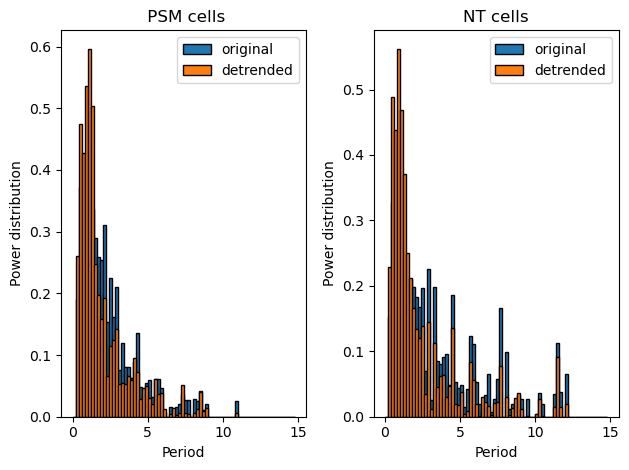

In [12]:
# Compute the Fourier analysis for PSM cells and NT cells
period_array_PSM, magnitudes_array_PSM, weighted_mean_PSM_data, weighted_std_PSM_data = Fourier_analysis('PSM', trending = False)
period_array_NT, magnitudes_array_NT, weighted_mean_NT_data, weighted_std_NT_data = Fourier_analysis('NT', trending = False)
period_array_PSM_detrend, magnitudes_array_PSM_detrend, weighted_mean_PSM_detrend, weighted_std_PSM_detrend = Fourier_analysis('PSM', trending = True)
period_array_NT_detrend, magnitudes_array_NT_detrend, weighted_mean_NT_detrend, weighted_std_NT_detrend = Fourier_analysis('NT', trending = True)

print('PSM cells: Weighted mean from data:', weighted_mean_PSM_data, 'Weighted std:', weighted_std_PSM_data, 'Coeff of variance of the weighted mean:', weighted_std_PSM_data/weighted_mean_PSM_data)
print('NT cells: Weighted mean from data:', weighted_mean_NT_data, 'Weighted std:', weighted_std_NT_data, 'Coeff of variance of the weighted mean:', weighted_std_NT_data/weighted_mean_NT_data)

def histogram(period_array, magnitudes_array, type, plot = False):
    # Compute the histogram with automatic bins
    bins = np.arange(0, 15, 0.2)
    hist, bin_edges = np.histogram(period_array, bins=bins, weights=magnitudes_array, density=True)
    fwhm, half_max = compute_fwhm(hist, bin_edges)

    if plot:
        # Plot the histogram
        plt.figure()
        plt.bar(bin_edges[:-1], hist, width=np.diff(bin_edges), edgecolor="black", align="edge")
        plt.axhline(half_max, color='red', linestyle='--', label=f'Half Maximum: {fwhm:.2f} hours')
        plt.xlabel('Period')
        plt.ylabel('Power distribution')
        plt.title(type)
        plt.legend()
        plt.show()

    return hist, bin_edges, fwhm, half_max

# Compute the histogram with automatic bins for both types
bins = np.arange(0, 15, 0.2)

PSM_hist, PSM_bins, PSM_fwhm, PSM_half_max = histogram(period_array_PSM, magnitudes_array_PSM, 'PSM cells')
NT_hist, NT_bins, NT_fwhm, NT_half_max = histogram(period_array_NT, magnitudes_array_NT, 'NT cells')
PSM_detrend_hist, PSM_detrend_bins, PSM_detrend_fwhm, PSM_detrend_half_max = histogram(period_array_PSM_detrend, magnitudes_array_PSM_detrend, 'PSM cells detrended')
NT_detrend_hist, NT_detrend_bins, NT_detrend_fwhm, NT_detrend_half_max = histogram(period_array_NT_detrend, magnitudes_array_NT_detrend, 'NT cells detrended')

plt.figure()
plt.subplot(1,2,1)
plt.bar(PSM_bins[:-1], PSM_hist, width=np.diff(PSM_bins), edgecolor="black", align="edge", label = 'original')
plt.bar(PSM_detrend_bins[:-1], PSM_detrend_hist, width=np.diff(PSM_detrend_bins), edgecolor="black", align="edge", label = 'detrended')
plt.xlabel('Period')
plt.ylabel('Power distribution')
plt.title(' PSM cells')
plt.legend()

plt.subplot(1,2,2)
plt.bar(NT_bins[:-1], NT_hist, width=np.diff(NT_bins), edgecolor="black", align="edge", label = 'original')
plt.bar(NT_detrend_bins[:-1], NT_detrend_hist, width=np.diff(NT_detrend_bins), edgecolor="black", align="edge", label = 'detrended')
plt.xlabel('Period')
plt.ylabel('Power distribution')
plt.title('NT cells')
plt.tight_layout()
plt.legend()

# hist_PSM, bin_edges_PSM = np.histogram(period_array_PSM, bins=bins, weights=magnitudes_array_PSM, density=True)
# hist_NT, bin_edges_NT = np.histogram(period_array_NT, bins=bins, weights=magnitudes_array_NT, density=True)

# fwhm_PSM, half_max_PSM = compute_fwhm(hist_PSM, bin_edges_PSM)
# fwhm_NT, half_max_NT = compute_fwhm(hist_NT, bin_edges_NT)

# # Plot the histograms
# plt.figure()
# plt.subplot(1,2,1)
# plt.bar(bin_edges_PSM[:-1], hist_PSM, width=np.diff(bin_edges_PSM), edgecolor="black", align="edge")
# plt.axhline(half_max_PSM, color='red', linestyle='--', label=f'Half Maximum: {fwhm_PSM:.2f} hours')
# #plt.plot(x_PSM, p_PSM, 'k', linewidth=2, label=f'Fit: $\mu$={weighted_mean_PSM:.2f}, $\sigma$={weighted_std_PSM:.2f}')
# plt.xlabel('Period')
# plt.ylabel('Power distribution')
# plt.title(' PSM cells')
# plt.legend()

# plt.subplot(1,2,2)
# plt.bar(bin_edges_NT[:-1], hist_NT, width=np.diff(bin_edges_NT), edgecolor="black", align="edge")   
# #plt.plot(x_NT, p_NT, 'k', linewidth=2, label=f'Fit: $\mu$={weighted_mean_NT:.2f}, $\sigma$={weighted_std_NT:.2f}')
# plt.axhline(half_max_NT, color='red', linestyle='--', label=f'Half Maximum: {fwhm_NT:.2f} hours')
# plt.xlabel('Period')
# plt.ylabel('Power distribution')
# plt.title('NT cells')
# plt.tight_layout()
# plt.legend()
# plt.show()

## Movement of cells

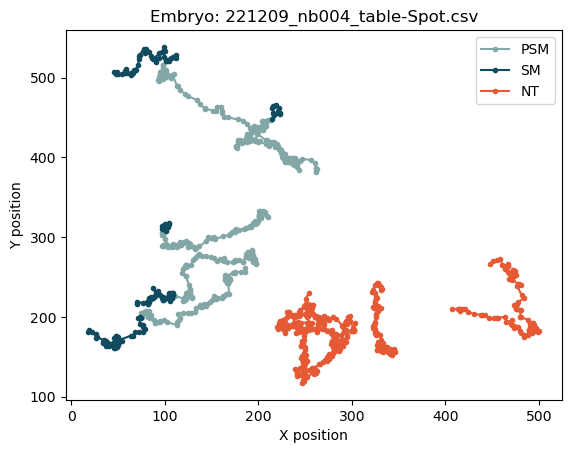

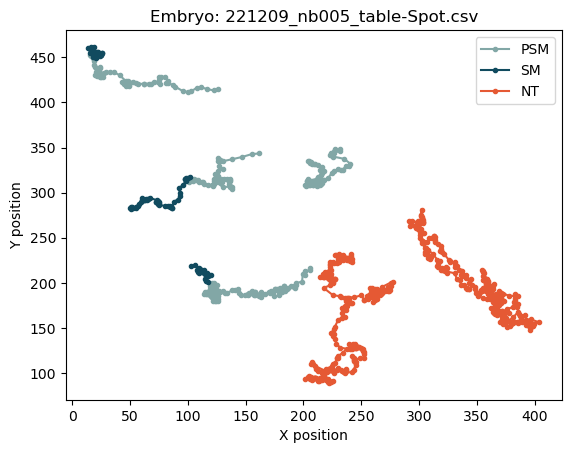

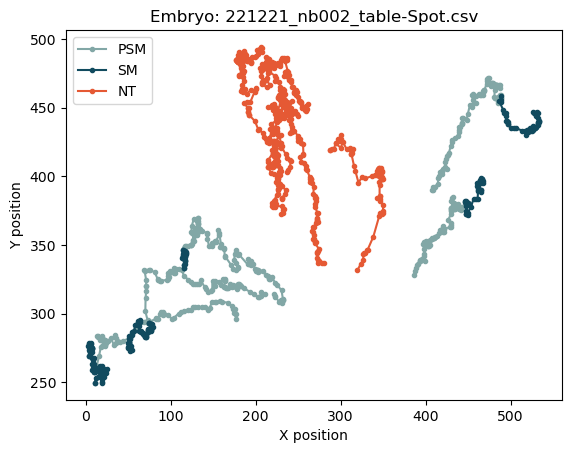

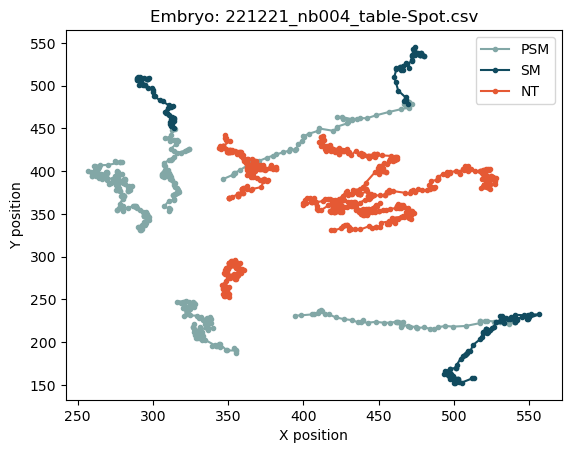

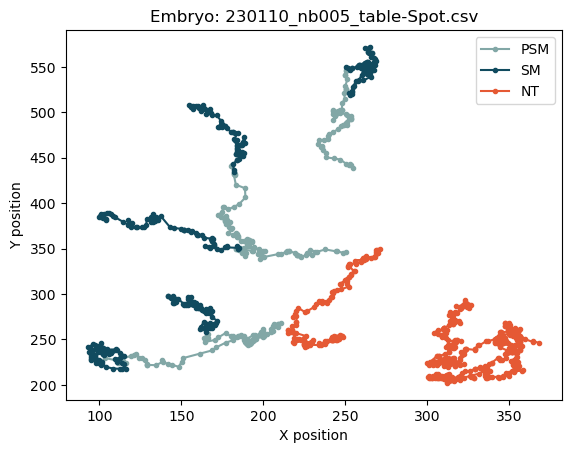

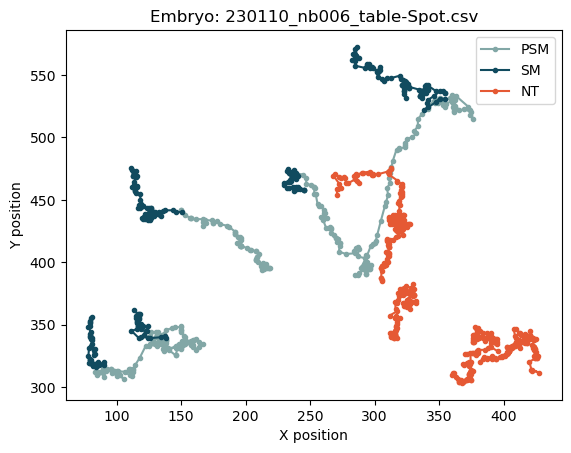

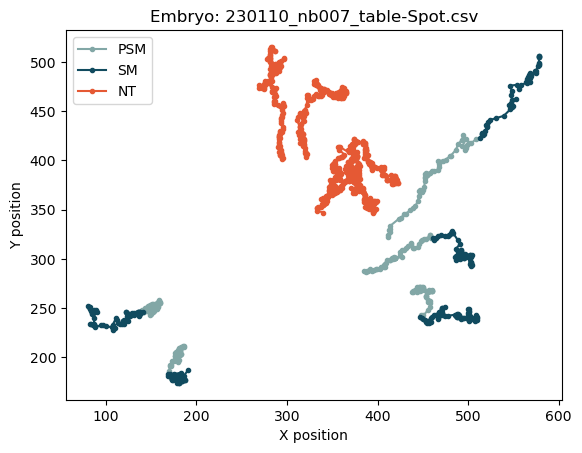

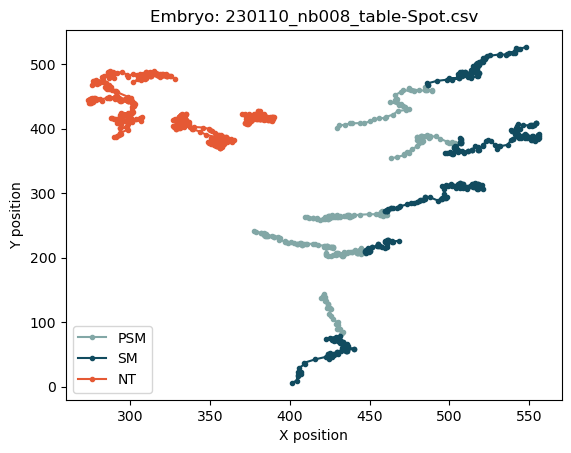

In [25]:
file_list = data['source_file'].unique()

for set in range(len(file_list)):
    plt.figure()

    for i in PSM_index:
        x_PSM = data_PSM[(data_PSM['Cell ID'] == i) & (data_PSM['source_file'] == file_list[set])]['Spot position X'].values
        y_PSM = data_PSM[(data_PSM['Cell ID'] == i) & (data_PSM['source_file'] == file_list[set])]['Spot position Y'].values

        if i == PSM_index[0]:
            plt.plot(x_PSM, y_PSM, marker='.', linestyle='-', color = colour_PSM, label = 'PSM')
        else:
            plt.plot(x_PSM, y_PSM, marker='.', linestyle='-', color = colour_PSM)

    for i in SM_index:
        x_SM = data_SM[(data_SM['Cell ID'] == i) & (data_SM['source_file'] == file_list[set])]['Spot position X'].values
        y_SM = data_SM[(data_SM['Cell ID'] == i) & (data_SM['source_file'] == file_list[set])]['Spot position Y'].values

        if i == SM_index[0]:
            plt.plot(x_SM, y_SM, marker='.', linestyle='-', color = colour_SM, label = 'SM')
        else:
            plt.plot(x_SM, y_SM, marker='.', linestyle='-', color = colour_SM)
    
    for i in NT_index:
        x_NT = data_NT[(data_NT['Cell ID'] == i) & (data_NT['source_file'] == file_list[set])]['Spot position X'].values
        y_NT = data_NT[(data_NT['Cell ID'] == i) & (data_NT['source_file'] == file_list[set])]['Spot position Y'].values

        if i == NT_index[0]:
            plt.plot(x_NT, y_NT, marker='.', linestyle='-', color = colour_NT, label = 'NT')
        else:
            plt.plot(x_NT, y_NT, marker='.', linestyle='-', color = colour_NT)

    plt.title(f'Embryo: {file_list[set]}')
    plt.xlabel('X position')
    plt.ylabel('Y position')
    plt.legend()
    plt.show()

In [ ]:
from matplotlib.colors import Normalize
from matplotlib.cm import ScalarMappable

for set in file_list:
    plt.figure()

    plt.subplot(1,2,1)
    for i in PSM_index:
        x_PSM = data_PSM[(data_PSM['Cell ID'] == i) & (data_PSM['source_file'] == file_list[set])]['Spot position X'].values
        y_PSM = data_PSM[(data_PSM['Cell ID'] == i) & (data_PSM['source_file'] == file_list[set])]['Spot position Y'].values

        if i == PSM_index[0]:
            plt.plot(x_PSM, y_PSM, marker='.', linestyle='-', color = colour_PSM, label = 'PSM')
        else:
            plt.plot(x_PSM, y_PSM, marker='.', linestyle='-', color = colour_PSM)

    for i in SM_index:
        x_SM = data_SM[(data_SM['Cell ID'] == i) & (data_SM['source_file'] == file_list[set])]['Spot position X'].values
        y_SM = data_SM[(data_SM['Cell ID'] == i) & (data_SM['source_file'] == file_list[set])]['Spot position Y'].values

        if i == SM_index[0]:
            plt.plot(x_SM, y_SM, marker='.', linestyle='-', color = colour_SM, label = 'SM')
        else:
            plt.plot(x_SM, y_SM, marker='.', linestyle='-', color = colour_SM)
    
    for i in NT_index:
        x_NT = data_NT[(data_NT['Cell ID'] == i) & (data_NT['source_file'] == file_list[set])]['Spot position X'].values
        y_NT = data_NT[(data_NT['Cell ID'] == i) & (data_NT['source_file'] == file_list[set])]['Spot position Y'].values

        if i == NT_index[0]:
            plt.plot(x_NT, y_NT, marker='.', linestyle='-', color = colour_NT, label = 'NT')
        else:
            plt.plot(x_NT, y_NT, marker='.', linestyle='-', color = colour_NT)
    
    plt.subplot(1,2,2)
    # Normalize the signal for color mapping
    norm = Normalize(vmin=np.min(signal), vmax=np.max(signal))
    cmap = plt.get_cmap('viridis')

    # Plot each segment with a color corresponding to the signal value
    x
    for i in range(len(x_position) - 1):
        plt.plot(x_position[i:i+2], y_position[i:i+2], color=cmap(norm(signal[i])), linewidth=2)

    # Add a color bar
    sm = ScalarMappable(cmap=cmap, norm=norm)
    sm.set_array([])  # Dummy array for the color bar
    plt.colorbar(sm, label='Signal Strength')

    # Add labels and title
    plt.title("Trajectory with Signal Strength")
    plt.xlabel("X")
    plt.ylabel("Y")